In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import numpy as np
from torchvision import datasets, models, transforms
import os
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image
from torch.utils.data import Dataset
from torch.autograd import Variable
import time

In [2]:
data_dir = 'F:\DataSets/EmotionImages/TargetData'

data_transform = {x: transforms.Compose([transforms.Resize([224, 224]),  # 设置尺寸
                                        transforms.ToTensor(),  # 转为Tensor
                                        transforms.Normalize([0.485, 0.456, 0.406],
                                                             [0.229, 0.224, 0.225])])  # 标准化
                  for x in {"train", "valid"}}  # {"train":"训练集数据格式","valid":"测试集数据格式"}

image_datasets = {x: datasets.ImageFolder(root=os.path.join(data_dir, x),  # 载入数据
                                         transform = data_transform[x])
                  for x in {"train", "valid"}}  # {"train":"训练集","valid":"测试集"}

dataloader = {x: torch.utils.data.DataLoader(dataset=image_datasets[x],
                                            batch_size=16,
                                            shuffle=True)
              for x in {"train", "valid"}}  # {包装16个为一个批次"train":"训练集数据载入","valid":"测试集数据载入"}

In [3]:
train_data = dataloader["train"]
valid_data = dataloader["valid"]

train_data_size = len(image_datasets["train"])
valid_data_size = len(image_datasets["valid"])

print(train_data_size)
print(valid_data_size)

1848
231


In [4]:
my_model = models.densenet121(pretrained=True)  # 网络预训练好的模型

In [5]:
print(my_model)

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [6]:
for param in my_model.parameters():
    param.requires_grad = False

In [7]:
my_model.classifier = nn.Sequential(
    nn.Linear(1024, 224),
    nn.ReLU(),
#     nn.Dropout(0.4),
    nn.Linear(224, 3),
    nn.LogSoftmax(dim=1)
)

In [8]:
loss_func = nn.NLLLoss()
optimizer = optim.Adam(my_model.parameters())

In [9]:
def train_and_valid(model, loss_function, optimizer, epochs=25):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    history = []
    best_acc = 0.0
    best_epoch = 0
 
    for epoch in range(epochs):
        epoch_start = time.time()
        print("Epoch: {}/{}".format(epoch+1, epochs))
 
        model.train()
 
        train_loss = 0.0
        train_acc = 0.0
        valid_loss = 0.0
        valid_acc = 0.0
 
        for i, (inputs, labels) in enumerate(train_data):
            inputs = inputs.to(device)
            labels = labels.to(device)
 
            #因为这里梯度是累加的，所以每次记得清零
            optimizer.zero_grad()
 
            outputs = model(inputs)
 
            loss = loss_function(outputs, labels)
 
            loss.backward()
 
            optimizer.step()
 
            train_loss += loss.item() * inputs.size(0)
 
            ret, predictions = torch.max(outputs.data, 1)
            correct_counts = predictions.eq(labels.data.view_as(predictions))
 
            acc = torch.mean(correct_counts.type(torch.FloatTensor))
 
            train_acc += acc.item() * inputs.size(0)
 
        with torch.no_grad():
            model.eval()
 
            for j, (inputs, labels) in enumerate(valid_data):
                inputs = inputs.to(device)
                labels = labels.to(device)
 
                outputs = model(inputs)
 
                loss = loss_function(outputs, labels)
 
                valid_loss += loss.item() * inputs.size(0)
 
                ret, predictions = torch.max(outputs.data, 1)
                correct_counts = predictions.eq(labels.data.view_as(predictions))
 
                acc = torch.mean(correct_counts.type(torch.FloatTensor))
 
                valid_acc += acc.item() * inputs.size(0)
 
        avg_train_loss = train_loss/train_data_size
        avg_train_acc = train_acc/train_data_size
 
        avg_valid_loss = valid_loss/valid_data_size
        avg_valid_acc = valid_acc/valid_data_size
 
        history.append([avg_train_loss, avg_valid_loss, avg_train_acc, avg_valid_acc])
 
        if best_acc < avg_valid_acc:
            best_acc = avg_valid_acc
            best_epoch = epoch + 1
 
        epoch_end = time.time()
 
        print("Epoch: {:03d}, Training: Loss: {:.4f}, Accuracy: {:.4f}%, \n\t\tValidation: Loss: {:.4f}, Accuracy: {:.4f}%, Time: {:.4f}s".format(
            epoch+1, avg_valid_loss, avg_train_acc*100, avg_valid_loss, avg_valid_acc*100, epoch_end-epoch_start
        ))
        print("Best Accuracy for validation : {:.4f} at epoch {:03d}".format(best_acc, best_epoch))
 
        torch.save(model, 'F:\DataSets/modles/'+'denseNet121_'+str(epoch+1)+'.pt')
    return model, history

In [10]:
num_epochs = 30
trained_model, history = train_and_valid(my_model, loss_func, optimizer, num_epochs)

Epoch: 1/30
Epoch: 001, Training: Loss: 0.5107, Accuracy: 69.4264%, 
		Validation: Loss: 0.5107, Accuracy: 77.0563%, Time: 1407.7651s
Best Accuracy for validation : 0.7706 at epoch 001


E:\Anaconda3\lib\site-packages\torch\serialization.py:292: UserWarning: Couldn't retrieve source code for container of type DenseNet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
E:\Anaconda3\lib\site-packages\torch\serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Sequential. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
E:\Anaconda3\lib\site-packages\torch\serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Conv2d. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
E:\Anaconda3\lib\site-packages\torch\serialization.py:292: UserWarning: Couldn't retrieve source code for container of type BatchNorm2d. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
E:\Anaconda3\lib\site-packages\torch\serialization.py

Epoch: 2/30
Epoch: 002, Training: Loss: 0.5441, Accuracy: 79.0043%, 
		Validation: Loss: 0.5441, Accuracy: 76.1905%, Time: 1349.9753s
Best Accuracy for validation : 0.7706 at epoch 001
Epoch: 3/30
Epoch: 003, Training: Loss: 0.4473, Accuracy: 82.7922%, 
		Validation: Loss: 0.4473, Accuracy: 80.5195%, Time: 1271.7364s
Best Accuracy for validation : 0.8052 at epoch 003
Epoch: 4/30
Epoch: 004, Training: Loss: 0.5359, Accuracy: 83.1710%, 
		Validation: Loss: 0.5359, Accuracy: 75.7576%, Time: 1332.1135s
Best Accuracy for validation : 0.8052 at epoch 003
Epoch: 5/30
Epoch: 005, Training: Loss: 0.5506, Accuracy: 83.4957%, 
		Validation: Loss: 0.5506, Accuracy: 77.9221%, Time: 1331.5642s
Best Accuracy for validation : 0.8052 at epoch 003
Epoch: 6/30
Epoch: 006, Training: Loss: 0.4823, Accuracy: 83.1169%, 
		Validation: Loss: 0.4823, Accuracy: 82.2511%, Time: 1320.4137s
Best Accuracy for validation : 0.8225 at epoch 006
Epoch: 7/30
Epoch: 007, Training: Loss: 0.5255, Accuracy: 85.3355%, 
		Vali

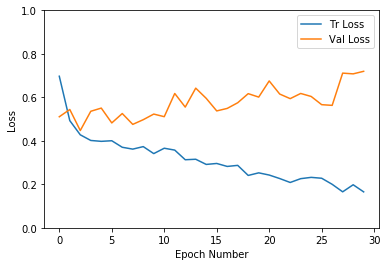

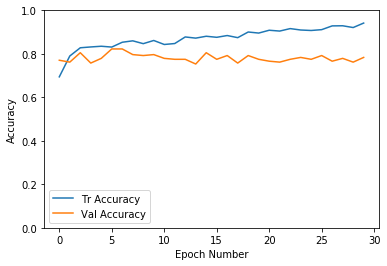

In [11]:
torch.save(history, 'F:\DataSets/modles/history/'+'denseNet121' + '_history.pt')

history = np.array(history)
plt.plot(history[:, 0:2])
plt.legend(['Tr Loss', 'Val Loss'])
plt.xlabel('Epoch Number')
plt.ylabel('Loss')
plt.ylim(0, 1)
# plt.savefig('resnet101_loss_curve.png')
plt.show()
 
plt.plot(history[:, 2:4]) 
plt.legend(['Tr Accuracy', 'Val Accuracy'])
plt.xlabel('Epoch Number')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
# plt.savefig('resnet101_accuracy_curve.png')
plt.show()